# Nearest Neighbor Item Based Collaborative Filtering
---
> 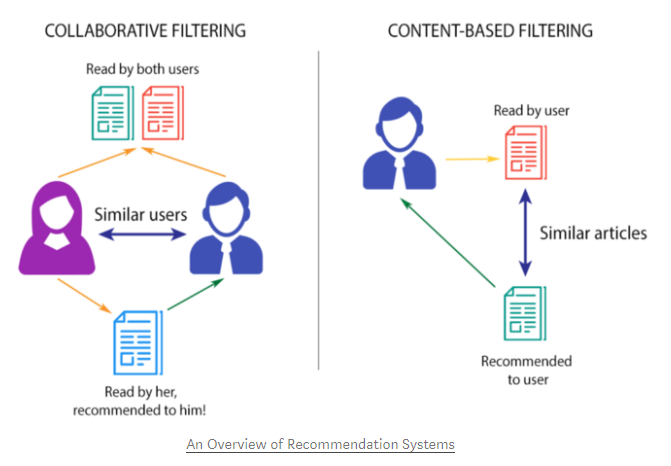

> Source: https://towardsdatascience.com

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparce import csr_matrix
from sklearn.neighbors import NearestNeighbors

## Importing the Dataset
> The Dataset has been imported from grouplens.org
> <br>
> Dataset Url : https://grouplens.org/datasets/movielens/latest/

In [28]:
# Reading the dataset as a Pandas Dataframe

movies_df = pd.read_csv('./data/movies.csv', usecols=['movieId', 'title'], dtype={'movieId': 'int32', 'title': 'str'})
ratings_df = pd.read_csv('./data/ratings.csv', usecols=['userId', 'movieId', 'rating'], dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [29]:
movies_df.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [30]:
ratings_df.head()

,userId,movieId,rating
0,1,1,4.00
1,1,3,4.00
2,1,6,4.00
3,1,47,5.00
4,1,50,5.00


## Exploratory Data Analysis
> Let's merge the `movies_df` and the `ratings_df` datasets

In [38]:
movies_df.shape, ratings_df.shape

((9742, 2), (100836, 3))

In [31]:
df = movies_df.merge(ratings_df, on = 'movieId')
df.head()

,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.00
1,1,Toy Story (1995),5,4.00
2,1,Toy Story (1995),7,4.50
3,1,Toy Story (1995),15,2.50
4,1,Toy Story (1995),17,4.50


In [40]:
df.shape

(100836, 4)

> Create a new dataframe with `title` and `totalRatingCount` as features. 

In [32]:
# Droping the NaN values
combine_movie_rating = df.dropna(axis=0, subset=['title'])

# Creating a new dataset with title and totalRatingCount columns
movie_rating_count = combine_movie_rating.groupby('title')['rating'].count().reset_index().rename(columns={'rating': 'totalRatingCount'})
movie_rating_count.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


> Now let's merge this `totalRatingCount` with the `combine_movie_rating` dataset

In [33]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_rating_count, on = 'title')
rating_with_totalRatingCount.head()

,movieId,title,userId,rating,totalRatingCount
0,1,Toy Story (1995),1,4.00,215
1,1,Toy Story (1995),5,4.00,215
2,1,Toy Story (1995),7,4.50,215
3,1,Toy Story (1995),15,2.50,215
4,1,Toy Story (1995),17,4.50,215


In [34]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(movie_rating_count['totalRatingCount'].describe())

count   9719.00
mean      10.38
std       22.41
min        1.00
25%        1.00
50%        3.00
75%        9.00
max      329.00
Name: totalRatingCount, dtype: float64


> Plotting the movie rating counts distribution using histogram

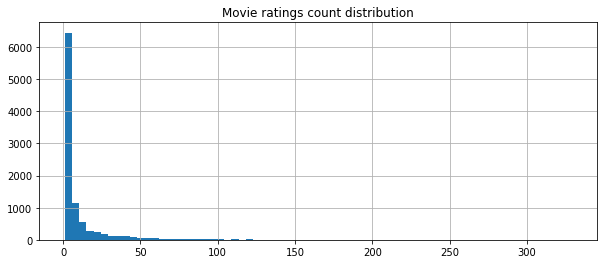

In [35]:
plt.figure(figsize=(10, 4))
movie_rating_count['totalRatingCount'].hist(bins=70)
plt.title('Movie ratings count distribution');

> From the above we can fix the movie ratings count threshold to 50

In [37]:
popularity_threshold = 50
rating_popular_movie = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head()

,movieId,title,userId,rating,totalRatingCount
0,1,Toy Story (1995),1,4.00,215
1,1,Toy Story (1995),5,4.00,215
2,1,Toy Story (1995),7,4.50,215
3,1,Toy Story (1995),15,2.50,215
4,1,Toy Story (1995),17,4.50,215


In [39]:
rating_popular_movie.shape

(41362, 5)

> Let's create Pivot table with `title` as index, `userId` as columns and `rating` as values and convert it to matrix using `csr_matrix` class of `scipy.sparse`

In [41]:
movie_features_df = rating_popular_movie.pivot_table(index = 'title', columns = 'userId', values = 'rating').fillna(0)
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,3.00,3.00,0.00,0.00,3.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00
12 Angry Men (1957),0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,5.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2001: A Space Odyssey (1968),0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,3.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,2.00,3.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,...,0.00,0.00,5.00,0.00,0.00,0.00,3.00,0.00,0.00,3.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,5.00,4.00,0.00,0.00,5.00,0.00,0.00,5.00,0.00,3.00,0.00,4.50
28 Days Later (2002),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,0.00,0.00,0.00,0.00,0.00,0.00,1.50,0.00,0.00,0.00,0.00,0.00,3.00,4.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,4.50,0.00,0.00,0.00,0.00,0.00,4.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,3.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,0.00,5.00
300 (2007),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,0.00,0.00,3.50,0.00,0.00,4.00,0.00,0.00,0.00,4.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,4.50,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,5.00,0.00,4.00


> Applying Nearest Neighbors (unsupervised ML) algorithm on the matrix that has been created. Here we will use the `cosine sililarity` as metric
> <br>
> 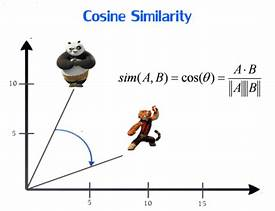
> <br> 
> From the above figure we can say that as the angle between the two vectors increases, the similarity value decreases

In [43]:
from scipy.sparse import csr_matrix
movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [44]:
movie_features_df.shape

(450, 606)

In [54]:
# Getting the index(movie name) of a randomly picked rating
query_index = np.random.choice(movie_features_df.shape[0])
print(query_index)

# Finding similar movies
distances, indices = model_knn.kneighbors(movie_features_df.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 6)

241


In [53]:
movie_features_df.head(3)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,570,571,572,573,574,575,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10 Things I Hate About You (1999),0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,3.00,3.00,0.00,0.00,3.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00
12 Angry Men (1957),0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,5.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2001: A Space Odyssey (1968),0.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,3.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,2.00,3.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,...,0.00,0.00,5.00,0.00,0.00,0.00,3.00,0.00,0.00,3.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,0.00,5.00,4.00,0.00,0.00,5.00,0.00,0.00,5.00,0.00,3.00,0.00,4.50


> Finding the similar movies

In [55]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {movie_features_df.index[query_index]}: \n ')
    else: 
        print(f'{i}: {movie_features_df.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}')

Recommendations for Legally Blonde (2001): 
 
1: Miss Congeniality (2000), with distance of 0.39422106742858887
2: Bridget Jones's Diary (2001), with distance of 0.4827796220779419
3: What Women Want (2000), with distance of 0.515329122543335
4: Moulin Rouge (2001), with distance of 0.5300582051277161
5: Shrek (2001), with distance of 0.541927695274353
